In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import date
import statistics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
gauth = GoogleAuth()
gauth.CommandLineAuth()
drive = GoogleDrive(gauth)

In [2]:
# set the doctor to analyse
data_path = '/home/jupyter/charliemacuject/pharma_reports/data'
doctor_path = data_path + '/eric_mayer.csv'
general_path = '/home/jupyter/charliemacuject/pharma_reports/nAMD'

In [4]:
def interval_column(df):
    id_list = df.id.unique()
    df.admission_date = pd.to_datetime(df.admission_date, dayfirst=True)
    frames = []
    for eye in id_list:
        interval_list = [0]
        pdf = df[df.id == eye]
        pdf.sort_values(by=['admission_date'], inplace=True)
        for i in range(len(pdf)-1):
            interval = np.round((pdf.admission_date.iloc[i+1] - pdf.admission_date.iloc[i]).days / 7)
            interval_list.append(interval)
        pdf['Interval'] = interval_list
        frames.append(pdf)
    return pd.concat(frames)

def year_clean(df):
    id_list = df.id.unique()
    df.admission_date = pd.to_datetime(df.admission_date, dayfirst=True)
    frames = []
    cutoff = pd.to_datetime('2016-01-01')
    for eye in id_list:
        pdf = df[df.id == eye]
        pdf.sort_values(by=['admission_date'], inplace=True)
        if pdf.admission_date.iloc[0] > cutoff:
            frames.append(pdf)
    return pd.concat(frames)

In [3]:
class DataSeparator:
    """
    A class used to segment the dataset in different ways.

    ...

    Attributes
    ----------
    df_list : str
        a formatted string to determine subset of patients being analysed
        options: 
            - 'drugs': segment patients by those on single vs mult drugs
            - 'improved': segment patients by those who improved vs didn't
            - 'switched': segment patients by switches (L to E, E to L only)
            - 'all': segment by all of the above

    Methods
    -------
    get_df(self, drop_drug_na=False)
        Retrieves the specific dataset from the path.
        'drop_drug_na=True' will remove NAs and Brolucizumab from 'Drug' column.
    get_dataframes(self)
        Produces a list of dataframes based on df_list segmentation query.
    drug_df_separator(self)
        Segments the dataset by patients on single vs mult drugs.
    improved_df_separator(self)
        Segments the dataset by patients who improved vs didn't.
    switch_df_separator(self)
        Segments the dataset by patients who switched.
        Lucentis to Eylea, Eylea to Lucentis switches only.
    """
    
    def __init__(self, df_list):
        self.df_list = df_list
        
    def get_df(self, drop_drug_na=False):
        """
        Retrieves the specific dataset from the path.
        Input: Bool.
        Output: Pandas dataframe.
        """
        df = pd.read_csv(doctor_path)
        df['admission_date'] = pd.to_datetime(df['admission_date'], dayfirst=True)
        df.rename(columns={'InjToday': 'Drug'}, inplace=True)
        df['admission_date'] = pd.to_datetime(df['admission_date'], dayfirst=True)
        if drop_drug_na:
            df = df.dropna(subset=['Drug'])
            df = df[df['Drug'] != 'nil']
            df = df[df['Drug'] != 'None']
            df = df[df['Drug'] != 'Brolucizumab']
        return df
    
    def get_dataframes(self):
        """
        Produces a list of dataframes based on df_list segmentation query.
        Input: self.
        Output: [Pandas dataframe].
        """
        if self.df_list == 'drugs':
            lucentis_df, eylea_df, mult_df = self.drug_df_separator()
            return [lucentis_df, eylea_df, mult_df]
        elif self.df_list == 'switched':
            luc_eyl, eyl_luc = self.switch_df_separator()
            luc_eyl
            return [luc_eyl, eyl_luc]
        elif self.df_list == 'improved':
            improved, not_improved, overall = self.improved_df_separator()
            return [improved, not_improved, overall]
        elif self.df_list == 'all':
            lucentis_df, eylea_df, mult_df = self.drug_df_separator()
            improved, not_improved, overall = self.improved_df_separator()
            luc_eyl, eyl_luc = self.switch_df_separator()
            return [lucentis_df, eylea_df, mult_df, improved, not_improved, overall, luc_eyl, eyl_luc]
        
    def drug_df_separator(self):
        """
        Produces a list of dataframes based single vs mult drugs.
        Input: self.
        Output: [Pandas dataframe].
        """
        df = self.get_df(drop_drug_na=True)
        df = df.dropna(subset=['Drug'])
        lucentis, eylea, avastin, mult = [], [], [], []
        drug_list = ['Lucentis', 'Eylea', 'Avastin']
        id_list = df['id'].unique()
        for eye in id_list:
            pdf = df[df['id'] == eye]
            drugs = pdf['Drug'].unique()
            if len(drugs) == 1:
                if drugs[0] == 'Lucentis':
                    lucentis.append(pdf)
                elif drugs[0] == 'Eylea':
                    eylea.append(pdf)
                else:
                    avastin.append(pdf)
            else:
                mult.append(pdf)
        return pd.concat(lucentis), pd.concat(eylea), pd.concat(mult)
    

    def improved_df_separator(self):
        """
        Produces a list of dataframes based on improvement.
        Input: self.
        Output: [Pandas dataframe].
        """
        df = self.get_df()
        improved, not_improved = [], []
        id_list = df['id'].unique()
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            pdf.sort_values(by=['admission_date'], inplace=True)
            vision = pdf['visual_acuity'].to_list()
            if max(vision) == vision[0]:
                not_improved.append(pdf)
            else:
                improved.append(pdf)
        return pd.concat(improved), pd.concat(not_improved), df
    
    def switch_df_separator(self):
        """
        Produces a list of dataframes based on switches.
        Input: self.
        Output: [Pandas dataframe].
        """
        df = self.get_df(drop_drug_na=True)
        df = df[df['Drug'] != 'Avastin']
        luc_eyl, eyl_luc = [], []
        drug_list = ['Lucentis', 'Eylea']
        id_list = df['id'].unique()
        for eye in id_list:
            pdf = df[df['id'] == eye]
            drugs = pdf['Drug'].unique()
            if len(drugs) > 1:
                if drugs[0] == 'Lucentis' and drugs[1] == 'Eylea':
                    luc_eyl.append(pdf)
                elif drugs[0] == 'Eylea' and drugs[1] == 'Lucentis':
                    eyl_luc.append(pdf)
            else:
                pass
        return pd.concat(luc_eyl), pd.concat(eyl_luc)

In [24]:
test = DataSeparator('all')
a = test.get_dataframes()
len(a)

8

In [18]:
class InitialMetrics(DataSeparator):
    
    def __init__(self, df_list):
        self.df_list = df_list
    
    def study_period(self, df):
        """
        Returns the study period in question.
        Input: Pandas dataframe.
        Output: datetime object x 2.
        """
        dates = df['admission_date']
        return dates.min(), dates.max()
    
    def num_patients(self, df):
        """
        Returns the number of patients treated.
        """
        return len(df['id'].unique())
    
    def num_eyes(self, df):
        """
        Returns the number of eyes treated.
        """
        return len(df['id'].unique())
    
    def total_visits(self, df):
        """
        Returns the number of total visits.
        """
        return len(df)
    
    def initiation_drug(self, df):
        '''
        Input: Pandas dataframe of all patients.
        Output: mean initiation drugs.
        '''
        id_list = df['id'].unique()
        lst, names = [], ['Lucentis', 'Eylea', 'Avastin']
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['Drug'], inplace=True)
            df = df[df['Drug'] != 'nil']
            df = df[df['Drug'] != 'None']
            if len(pdf['Drug']) != 0 and pdf['Drug'].iloc[0] in names:
                lst.append(pdf['Drug'].iloc[0])
        luc_int = np.round(lst.count('Lucentis') / len(lst), 3)
        eyl_int = np.round(lst.count('Eylea') / len(lst), 3)
        av_int = np.round(lst.count('Avastin') / len(lst), 3)
        return luc_int, eyl_int, av_int

    def irf_extred(self):
        # this function counts the irf values when extending and reducing
        df = self.interval_df()
        df.dropna(subset=['irf'], inplace=True)
        df = df[df['irf'] < 1000]
        id_list = df['id'].unique()
        irf_extend = []
        irf_reduce = []
        irf_maintain = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            for i in range(len(pdf)-1):
                if pdf['Interval'].iloc[i+1] > pdf['Interval'].iloc[i]:
                    irf_extend.append(pdf['irf'].iloc[i+1])
                elif pdf['Interval'].iloc[i+1] < pdf['Interval'].iloc[i]:
                    irf_reduce.append(pdf['irf'].iloc[i+1])    
                else:
                    irf_maintain.append(pdf['irf'].iloc[i+1])   
        return np.mean(irf_extend), np.mean(irf_reduce), np.mean(irf_maintain)
    
    # this function counts the srf values when extending and reducing
    def srf_extred(self):
        df = self.interval_df()
        df.dropna(subset=['srf'], inplace=True)
        df = df[df['srf'] < 1000]
        id_list = df['id'].unique()
        srf_extend = []
        srf_reduce = []
        srf_maintain = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            for i in range(len(pdf)-1):
                if pdf['Interval'].iloc[i+1] > pdf['Interval'].iloc[i]:
                    srf_extend.append(pdf['srf'].iloc[i+1])
                elif pdf['Interval'].iloc[i+1] < pdf['Interval'].iloc[i]:
                    srf_reduce.append(pdf['srf'].iloc[i+1])    
                else:
                    srf_maintain.append(pdf['srf'].iloc[i+1])   
        return np.mean(srf_extend), np.mean(srf_reduce), np.mean(srf_maintain)
    
            
    def patient_drugs(self):
        """
        Returns a percentage of patients on Lucentis, Eylea and multiple drugs.
        """
        df_list = DataSeparator.get_dataframes(self)
        luc_count = len(df_list[0].id.unique())
        eyl_count = len(df_list[1].id.unique())
        mult_count = len(df_list[2].id.unique())
        total = luc_count + eyl_count + mult_count
        return np.round((luc_count/total)*100), np.round((eyl_count/total)*100), np.round((mult_count/total)*100)
    
            
    def results_table(self):
        """
        Returns a dataframe of results for all initial metrics.
        Input: self.
        Output: Pandas dataframe.
        """
        df = DataSeparator.get_df(self)
        earliest, latest = self.study_period(df)
        luc_int, eyl_int, av_int = self.initiation_drug(df)
        luc_count, eyl_count, mult_count = self.patient_drugs()
        dict = {'Start': earliest, 'End': latest, 'Num_Patients': self.num_patients(df),
               'TotalVisits': self.total_visits(df), 'LucentisInit%': luc_int*100, 'EyleaInit%': eyl_int*100, 
                'AvastinInit%': av_int*100, 'Lucentis%': luc_count, 'Eylea%': eyl_count, 'Mult%': mult_count} 
        return pd.DataFrame(dict, index=[0])
    
    def upload_results_table(self):
        dataframe = self.results_table()
        dataframe.to_csv(general_path + '/initialmetrics.csv')

In [66]:
class Vision(DataSeparator):
    """
    A class used to produce common visual metrics.

    ...

    Attributes
    ----------
    df_list : str
        a formatted string to determine subset of patients being analysed
        options: 
            - 'drugs': segment patients by those on single vs mult drugs
            - 'improved': segment patients by those who improved vs didn't
            - 'switched': segment patients by switches (L to E, E to L only)
            - 'all': segment by all of the above

    Methods
    -------
    pvi(self, dataset)
        Produces a list of patient PVIs from dataset.
    tpvi(self, dataset)
        Produces a list of patient TPVIs from dataset.
    vlp(self, dataset)
        Produces a list of patient VLPs from dataset.
    ovc(self, dataset)
        Produces a list of patient OVCs from dataset.
    vision_weeks(self, weeks)
        Calculates the mean vision for all patients at a specific visit number.
    anchor(self, weeks)
        Produces a dataframe of mean vision over the first year, including trial results.
    list_results(self, dataset)
        Produces a list of above visual metrics (PVI, TPVI, VLP, OVC) for given dataset.
    list_sds(self, dataset)
        Produces a list of the 95% CI bounds for all visual metrics, for given dataset.
    results_table(self)
        Returns a Pandas dataframe of all visual metrics.
    """
    
    # df_list can be either drugs, improved, switched or all
    def __init__(self, df_list):
        self.df_list = df_list
    
    def pvi(self, df):
        """
        Produces a list of patient PVIs from dataset.
        Peak Visual Improvement (PVI) is defined as max vision minus initial vision.
        Input: Pandas dataframe.
        Output: list of LogMAR letters.
        """
        id_list = df['id'].unique()
        pvi_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                pvi_pdf = max(visions) - visions[0]
                pvi_list.append(pvi_pdf)
        return pvi_list
    
    def tpvi(self, df):
        """
        Produces a list of patient TPVIs from dataset.
        Time to Peak Visual Improvement (TPVI) is defined in days.
        Input: Pandas dataframe.
        Output: list of days.
        """
        id_list = df['id'].unique()
        tpvi_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            dates = pdf['admission_date'].to_list()
            initial_date = dates[0]
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                ndf = pdf[pdf['visual_acuity'] == max(visions)]
                new_dates = ndf['admission_date'].to_list()
                time = (new_dates[0] - initial_date).days
                tpvi_list.append(time)
        return tpvi_list
    
    def tpvi_injs(self, df):
        """
        Produces a list of patient TPVIs (in # of injs) from dataset.
        Input: Pandas dataframe.
        Output: list of days.
        """
        id_list = df['id'].unique()
        tpvi_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0: 
                max_value = max(visions)
                max_index = visions.index(max_value)
                tpvi_list.append(max_index)
        return tpvi_list
    
    def ovc(self, df):
        """
        Produces a list of patient OVCs from dataset.
        Overall Visual Change (OVC) is defined as last vision minus initial vision.
        Input: Pandas dataframe.
        Output: list of LogMAR letters.
        """
        id_list = df['id'].unique()
        ovc_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                ovc_list.append(visions[-1] - visions[0])
        return ovc_list
    
    def vlp(self, df):
        """
        Produces a list of patient VLPs from dataset.
        Vision Loss from Peak (VLP) is defined as max vision minus last vision.
        Input: Pandas dataframe.
        Output: list of LogMAR letters.
        """
        id_list = df['id'].unique()
        vlp_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                recent = visions[-1]
                max_vision = max(visions)
                vlp_list.append(max_vision - recent)
        return vlp_list
    
    def baseline(self, df):
        id_list = df.id.unique()
        baseline_list = []
        for eye in id_list:
            pdf = df[df.id == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            if len(pdf) > 0:
                if pdf.visual_acuity.iloc[0] != 0:
                    baseline_list.append(pdf.visual_acuity.iloc[0])
        return baseline_list
    
    def list_results(self, df):
        """
        Produces a list of the visual metrics defined (PVI, TPVI, VLP, OVC).
        Input: Pandas dataframe.
        Output: float x 4.
        """
        pvi_list, tpvi_list, tpvi_injs_list = self.pvi(df), self.tpvi(df), self.tpvi_injs(df), 
        vlp_list, ovc_list = self.vlp(df), self.ovc(df)
        baseline_list = self.baseline(df)
        return np.mean(pvi_list), np.mean(tpvi_list), np.mean(tpvi_injs_list), np.mean(vlp_list), np.mean(ovc_list), np.mean(baseline_list)
    
    def list_sds(self, df):
        """
        Produces a list of the 95% CI bounds for all visual metrics.
        Input: Pandas dataframe.
        Output: float x 4
        """
        pvi_list, tpvi_list, tpvi_injs_list = self.pvi(df), self.tpvi(df), self.tpvi_injs(df), 
        vlp_list, ovc_list, baseline_list = self.vlp(df), self.ovc(df), self.baseline(df)
        lst = [pvi_list, tpvi_list, tpvi_injs_list, vlp_list, ovc_list, baseline_list]
        to_return = []
        for item in lst:
            ci = stats.t.interval(alpha=0.95, df=len(item)-1, loc=np.mean(item), scale=stats.sem(item))
            std = np.mean(item) - ci[0]
            to_return.append(std)
        return np.round(to_return[0], 2), np.round(to_return[1], 2), np.round(to_return[2], 2), np.round(to_return[3], 2), np.round(to_return[4], 2), np.round(to_return[5], 2)
    
    def mean_vis(self, df):
        id_list = df['id'].unique()
        mean_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                mean_list.append(np.mean(visions))
        return mean_list
    
    def std_vis(self, df):
        id_list = df['id'].unique()
        std_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                std_list.append(np.std(visions))
        return std_list
            
    def results_table(self):
        """
        Returns a dataframe of results for all visual metrics.
        Input: self.
        Output: Pandas dataframe.
        """
        names = ['Lucentis', 'Eylea', 'Multiple', 'Improved', 'Not_Improved', 'Overall', 'Luc_to_Eyl', 'Eyl_to_Luc']
        df_lst = DataSeparator.get_dataframes(self)
        pvi, tpvi, tpvi_i, vlp, ovc, pvi_sd, tpvi_sd, tpvi_i_sd = [], [], [], [], [], [], [], [], 
        vlp_sd, ovc_sd, mean_vis, vis_std, base, base_sd = [], [], [], [], [], []
        for i in range(len(df_lst)):
            dataframe = df_lst[i]
            name = names[i]
            Pvi, Tpvi, Tpvi_I, Vlp, Ovc, Base = self.list_results(dataframe)
            Pvi_sd, Tpvi_sd, Tpvi_I_sd, Vlp_sd, Ovc_sd, Base_sd = self.list_sds(dataframe)
            mean_vision = np.mean(self.mean_vis(dataframe))
            vision_std = np.mean(self.std_vis(dataframe))
            pvi.append(Pvi), tpvi.append(Tpvi), tpvi_i.append(Tpvi_I), vlp.append(Vlp), ovc.append(Ovc)
            pvi_sd.append(Pvi_sd), tpvi_sd.append(Tpvi_sd), tpvi_i_sd.append(Tpvi_I_sd), vlp_sd.append(Vlp_sd)
            ovc_sd.append(Ovc_sd), mean_vis.append(mean_vision), vis_std.append(vision_std)
            base.append(Base), base_sd.append(Base_sd)
        dict = {'Drug': names, 'PVI': pvi, 'PVI_sd': pvi_sd, 'TPVI': tpvi, 'TPVI_sd': tpvi_sd, 'TPVI_Injs': tpvi_i,
                'TPVI_Injs_sd': tpvi_i_sd, 'VLP': vlp, 'VLP_sd': vlp_sd, 'OVC': ovc, 'OVC_sd': ovc_sd, 
                'MeanVis': mean_vis, 'StdVis': vis_std, 'Baseline': base, 'Baseline_sd': base_sd} 
        df = pd.DataFrame(dict)
        df.set_index('Drug', inplace=True)
        return df
    
    def upload_results_table(self):
        dataframe = self.results_table()
        dataframe.to_csv(general_path + '/visual_metrics.csv')
        drug_dist = self.va_dist_table()
        drug_dist.to_csv(general_path + '/drug_dist_table.csv')
        va_dist = self.va_distributions()
        va_dist.to_csv(general_path + '/va_distributions.csv')
        
    def patient_counts(self):
        df_list = DataSeparator.get_dataframes(self)
        counts = []
        for df in df_list:
            counts.append(len(df.id.unique()))
        return counts
    
    def va_distributions(self):
        """
        Outputs a list for each type of patient of VAs.
        This allows us to analyse the distribution of vision.
        """
        df_list = DataSeparator.get_dataframes(self)
        names = ['aVGF', 'Steroids', 'Both']
        luc_lst = self.va_dist_helper(df_list[0])
        eyl_lst = self.va_dist_helper(df_list[1])
        m_lst = self.va_dist_helper(df_list[2])
        dict = {'aVGF_Dist': pd.Series(luc_lst), 'Steroid_Dist': pd.Series(eyl_lst), 
                'Both_dist': pd.Series(m_lst)} 
        return pd.DataFrame(dict)
        
    
    def va_dist_helper(self, df):
        id_list = df.id.unique()
        lst = []
        for eye in id_list:
            pdf = df[df.id == eye]
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            lst.append(np.mean(pdf.visual_acuity))
        return lst
    
    def va_dist_table(self):
        """
        Outputs a table of distribution of VAs.
        This allows us to analyse the distribution of vision.
        """
        df_list = DataSeparator.get_dataframes(self)
        luc_list = self.va_dist_helper(df_list[0])
        eyl_list = self.va_dist_helper(df_list[1])
        m_list = self.va_dist_helper(df_list[2])
        names = ['Lucentis', 'Eylea', 'Multiple']
        means = [np.mean(luc_list), np.mean(eyl_list), np.mean(m_list)]
        medians = [np.median(luc_list), np.median(eyl_list), np.median(m_list)]
        stds = [np.std(luc_list), np.std(eyl_list), np.std(m_list)]
        maxs = [max(luc_list), max(eyl_list), max(m_list)]
        mins = [min(luc_list), min(eyl_list), min(m_list)]
        dict = {'Drug': names, 'Mean': means, 'Median': medians, 
               'StandardDev': stds, 'Maximum': maxs, 'Minimum': mins} 
        df = pd.DataFrame(dict)
        df.set_index('Drug', inplace=True)
        return df

In [17]:
test = DataSeparator("all")
df = test.get_df()
#luc, eyl, mult = df_list[0], df_list[1], df_list[2]
#len(luc), len(eyl), len(mult)

In [14]:
overall = df_list[-1]
luc_df = overall[overall.Drug == 'Lucentis']
eyl_df = overall[overall.Drug == 'Eylea']
luc_va = luc_df.visual_acuity
eyl_va = eyl_df.visual_acuity
mult_va = overall.visual_acuity

np.std(luc_va), np.std(eyl_va), np.std(mult_va)

(14.79602718730988, 20.390680250038322, 18.165842853059296)

In [13]:
luc_va = luc.visual_acuity
eyl_va = eyl.visual_acuity
mult_va = mult.visual_acuity

from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(luc_va, mult_va)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=1230856.000, p=0.012
Different distribution (reject H0)


In [55]:
test = DataSeparator("all")
luc, eyl, mult = test.improved_df_separator()

In [56]:
test = Vision('all')
luc = test.ovc(luc)
eyl = test.ovc(eyl)
mult = test.ovc(mult)
np.mean(luc), np.mean(eyl), np.mean(mult)

(-0.143646408839779, -11.462686567164178, -3.2016129032258065)

In [57]:
stat, p = mannwhitneyu(eyl, luc)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=2991.500, p=0.000
Different distribution (reject H0)


In [42]:
import statsmodels.stats.api as sms

sms.DescrStatsW(eyl).tconfint_mean()

(-6.243242705871308, 0.9432427058713078)

In [58]:
import math

class Anchor(DataSeparator):
    
    def __init__(self, subset, interval):
        super().__init__(subset)
        self.interval = interval
        
    
    def month_column(self, pdf, interval):
        """
        Appends month since starting as a column to patient df.
        Interval is the grouping of months i.e. 3 = 3 month intervals.
        Interval = 12 --> yearly intervals.
        """
        pdf.sort_values(by=['admission_date'], inplace=True)
        visions = pdf['visual_acuity'].to_list()
        initial_date = pdf.admission_date.iloc[0]
        months_list = [0]
        for i in range(len(pdf)-1):
            months = round((pdf.admission_date.iloc[i] - initial_date).days / 28)
            months_list.append(math.floor(months/interval))
        pdf['period_since_start'] = months_list
        return pdf
    
    def vision_month(self, period, interval):
        """
        Produces average vision at a certain visit after initiation.
        Input: dataframe, number of visits after initiation (int)
        Output: mean visual acuity of all patients at that visit
        """
        df = DataSeparator.get_df(self)
        id_list = df['id'].unique()
        df.dropna(subset=['visual_acuity'], inplace=True)
        lst = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.admisssion_date = pd.to_datetime(pdf.admission_date, dayfirst=True)
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf = self.month_column(pdf, interval)
            visions = pdf['visual_acuity'].to_list()
            for i in range(len(pdf)):
                if pdf.period_since_start.iloc[i] == period:
                    if pdf.visual_acuity.iloc[i] > 0:
                        lst.append(visions[i] - visions[0])
        return np.round(np.mean(lst), 2), np.round(np.std(lst), 2), len(lst)
    
    def anchor(self):
        """
        Produces a dataframe of mean vision over the first year, including trial results.
        Also produces the standard ANCHOR figures for the same period.
        Input: Pandas dataframe (all patients).
        Output: Pandas dataframe.
        """
        df_list = DataSeparator.get_dataframes(self)
        df = df_list[-1]
        anchor_list = [0]
        std_list = [0]
        length_list = [0]
        months = [x for x in range(13)]
        for i in range(12):
            mean, std, length = self.vision_month(i, self.interval)
            anchor_list.append(mean)
            std_list.append(std)
            length_list.append(length)
        period_string = str(self.interval)
        dict = {'Period('+period_string+'monthInts)': months, 'Doctor_Mean': anchor_list,
               'StdDeviation': std_list, 'No.Visits': length_list} 
        df = pd.DataFrame(dict)
        df.set_index('Period('+period_string+'monthInts)', inplace=True)
        return df
    
    def upload_results_table(self):
        dataframe = self.anchor()
        dataframe.to_csv(general_path + '/anchor.csv')

In [62]:
test = Anchor("all", 1)
test.anchor()

,Doctor_Mean,StdDeviation,No.Visits
Period(1monthInts),,,
0,0.00,0.00,0
1,0.22,7.00,532
2,0.71,9.18,118
3,1.90,7.55,136
4,-0.13,11.77,136
5,0.39,9.84,158
6,-0.30,9.06,132
7,0.21,10.92,124
8,-0.45,13.03,112


In [43]:
class Utilisation(DataSeparator):
    
    def get_df(self): return DataSeparator.get_df(self)
    
    def drug_totals(self, num_visits, drug_name):
        df = self.get_df()
        eye_list = df['id'].unique()
        drugs_list, names_list = [], ['Lucentis', 'Avastin', 'Eylea']
        for eye in eye_list:
            count, df_new = 0, df[df['id'] == eye]
            if len(df_new) > num_visits:
                for i in range(len(df_new)):
                    while count < num_visits:
                        date = df_new['admission_date'].iloc[i]
                        drug = df_new['Drug'].iloc[i]
                        if drug in names_list:
                            drugs_list.append(drug)
                        count += 1
                        i += 1
        length = len(drugs_list)
        count_drug = drugs_list.count(drug_name)
        return count_drug

    # this function recurses over all patients in dataframe
    def all_drugs(self, visit_num, drug_name):
        df = self.get_df()
        counts = []
        for i in range(1, visit_num+1):
            average_drug = self.drug_totals(i, drug_name)
            counts.append(average_drug)
        return counts
    
    # plot the figures
    def plot_ut(self):
        w, y, z = self.all_drugs(100, 'Lucentis'), self.all_drugs(100, 'Eylea'), self.all_drugs(100, 'Avastin')
        matplotlib.rcParams['font.size'] = 18
        x = list(range(1, 101))
        fig = plt.figure(figsize=(12, 7))
        ax = plt.axes()
        ax.set(xlabel='Visit Number', ylabel='Number of Injections Using Drug')
        ax.plot(x, w, label='Lucentis', color='#03254c')
        ax.plot(x, y, label='Eylea', color='#187bcd')
        ax.plot(x, z, label='Avastin', color='orange')
        ax.legend(loc='lower left')
        right_side = ax.spines["right"]
        left_side = ax.spines['left']
        top_side = ax.spines['top']
        right_side.set_visible(False)
        left_side.set_visible(False)
        top_side.set_visible(False)
        plt.savefig('ut_plot.png', dpi=300, bbox_inches='tight')

In [4]:
class Interval(DataSeparator):
    """
    A class used to produce common interval metrics.

    ...

    Methods
    -------
    interval_column(self, patient_dataset)
        Produces a patient dataframe with additional column for interval length.
    interval_all(self, dataset)
        Applies interval column to entire dataframe.
    """
    
    def get_df_list(self): return DataSeparator.get_dataframes(self)
    
    def interval_column(self, pdf):
        '''
        Input: patient dataframe.
        Output: patient dataframe with additional column for interval length.
        '''
        pdf.dropna(subset=['admission_date'], inplace=True)
        pdf['admission_date'] = pd.to_datetime(pdf['admission_date'], dayfirst=True)
        pdf = pdf.sort_values(by=['admission_date'])
        dates = pdf['admission_date'].reset_index(drop=True)
        weeks = [0]
        for i in range(len(dates)-1):
            week = int((dates[i+1] - dates[i]).days / 7)
            weeks.append(week)
        pdf['Interval'] = weeks
        return pdf.reset_index(drop=True)

    def interval_all(self):
        '''
        Input: whole dataframe.
        Output: whole dataframe with additional column for interval length.
        '''
        df_list = self.get_dataframes()
        new_list = []
        for df in df_list:
            id_list = df['id'].unique()
            frames = []
            for eye in id_list:
                pdf = df[df['id'] == eye]
                pdf = self.interval_column(pdf)
                frames.append(pdf)
            new_list.append(pd.concat(frames))
        return new_list
    
    def mean_intervals(self):
        """
        Returns the mean and std of interval length for different drugs.
        """
        df_list = self.interval_all()
        # df_list = df_list[0:3]
        mean_list, std_list, median_list, min_list, max_list = [], [], [], [], []
        for df in df_list:
            int_list = df.Interval.to_list()
            min_list.append(min(int_list))
            max_list.append(max(int_list))
            int_list = [x for x in int_list if x > 0 and x < 20]
            mean_list.append(np.mean(int_list))
            std_list.append(np.std(int_list))
            median_list.append(np.median(int_list))
        return mean_list, std_list, median_list, min_list, max_list
    
    def ext_patterns(self):
        df_list = self.interval_all()
        df = df_list[-3]
        id_list = df.id.unique()
        inj_ext, inj_ext_time, actual_ext = [], [], []
        for eye in id_list:
            pdf = df[df.id == eye]
            pdf.admission_date = pd.to_datetime(pdf.admission_date, dayfirst=True)
            pdf.sort_values(by=['admission_date'], inplace=True)
            for i in range(len(pdf)-1):
                if pdf.NextInt.iloc[i+1] > pdf.NextInt.iloc[i] and i != 0:
                    inj_ext.append(i+1)
                    end = pd.to_datetime(pdf.admission_date.iloc[i+1], dayfirst=True)
                    start = pd.to_datetime(pdf.admission_date.iloc[0], dayfirst=True)
                    ext_time = (end - start).days / 7
                    inj_ext_time.append(ext_time)
                    actual_ext.append(pdf.NextInt.iloc[i+1] - pdf.NextInt.iloc[i])
                    break
        return inj_ext, inj_ext_time, actual_ext
    
    def red_patterns(self):
        df_list = self.interval_all()
        df = df_list[-3]
        id_list = df.id.unique()
        inj_ext, inj_ext_time, actual_red = [], [], []
        for eye in id_list:
            pdf = df[df.id == eye]
            pdf.admission_date = pd.to_datetime(pdf.admission_date, dayfirst=True)
            pdf.sort_values(by=['admission_date'], inplace=True)
            for i in range(len(pdf)-1):
                if pdf.NextInt.iloc[i+1] < pdf.NextInt.iloc[i] and i>2:
                    inj_ext.append(i+1)
                    end = pd.to_datetime(pdf.admission_date.iloc[i+1], dayfirst=True)
                    start = pd.to_datetime(pdf.admission_date.iloc[0], dayfirst=True)
                    ext_time = (end - start).days / 7
                    inj_ext_time.append(ext_time)
                    actual_red.append(pdf.NextInt.iloc[i] - pdf.NextInt.iloc[i+1])
                    break
        return inj_ext, inj_ext_time, actual_red
            
    def results_table(self):
        """
        Returns a dataframe of results..
        Input: self.
        Output: Pandas dataframe.
        """
        names = ['Lucentis', 'Eylea', 'Multiple', 'Improved', 'Not_Improved', 'Overall', 'Luc_to_Eyl', 'Eyl_to_Luc']
        mean_list, std_list, median_list, min_list, max_list = self.mean_intervals()
        dict = {'Drug': names, 'mean_int': mean_list, 'mean_std': std_list,
                'median_int': median_list, 'min_int': min_list, 'max_int': max_list} 
        df = pd.DataFrame(dict)
        df.set_index('Drug', inplace=True)
        return df
    
    def ext_red_results(self):
        ext_red = ['Extension', 'Reduction']
        inj_ext, inj_ext_time, _ = self.ext_patterns()
        ext_mean, ext_mean_time = np.mean(inj_ext), np.mean(inj_ext_time)
        ext_median, ext_median_time = np.median(inj_ext), np.median(inj_ext_time)
        ext_min, ext_min_time = np.min(inj_ext), np.min(inj_ext_time)
        ext_max, ext_max_time = np.max(inj_ext), np.max(inj_ext_time)
        inj_red, inj_red_time, _ = self.red_patterns()
        red_mean, red_mean_time = np.mean(inj_red), np.mean(inj_red_time)
        red_median, red_median_time = np.median(inj_red), np.median(inj_red_time)
        red_min, red_min_time = np.min(inj_red), np.min(inj_red_time)
        red_max, red_max_time = np.max(inj_red), np.max(inj_red_time)
        dict = {'Type': ext_red, 'Mean': [ext_mean, red_mean], 'Median': [ext_median, red_median], 
                'Min': [ext_min, red_min], 'Max': [ext_max, red_max], 
                'MeanTime': [ext_mean_time, red_mean_time], 
                'MedianTime': [ext_median_time, red_median_time],
               'MinTime': [ext_min_time, red_min_time], 'MaxTime': [ext_max_time, red_max_time]} 
        df = pd.DataFrame(dict)
        df.set_index('Type', inplace=True)
        return df
    
    def upload_results_table(self):
        dataframe = self.results_table()
        dataframe.to_csv(general_path + '/drug_int_metrics.csv')
        df = self.ext_red_results()
        df.to_csv(general_path + '/interval_metrics.csv')
        interval_length = self.interval_distribution()
        interval_length.to_csv(general_path + '/interval_distribution.csv')
        int_dist = self.int_dist_plot()
        int_dist.to_csv(general_path + '/int_dist_plot.csv')
        
    def addYears(self, d, years):
        try:
        #Return same day of the current year        
            return d.replace(year = d.year + years)
        except ValueError:
        #If not same day, it will return other, i.e.  February 29 to March 1 etc.        
            return d + (date(d.year + years, 1, 1) - date(d.year, 1, 1))

        
    def year_split(self, df):
        """
        Splits the dataframe into first, second and third year (onwards) of treatment.
        """
        id_list = df.id.unique()
        year_1, year_2, year_3 = [], [], []
        for eye in id_list:
            pdf = df[df.id == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            initial = pdf.admission_date.iloc[0]
            cutoff1 = self.addYears(initial, 1)
            cutoff2 = self.addYears(initial, 2)
            pdf_1 = pdf[pdf.admission_date <= cutoff1]
            pdf_2 = pdf[(pdf.admission_date > cutoff1) & (pdf.admission_date < cutoff2)]
            pdf_3 = pdf[pdf.admission_date > cutoff2]
            year_1.append(pdf_1), year_2.append(pdf_2), year_3.append(pdf_3)
        return pd.concat(year_1), pd.concat(year_2), pd.concat(year_3)
    
    def number_injections(self, df):
        """
        Returns the average number of injections per patient.
        """
        id_list = df.id.unique()
        injs = []
        for eye in id_list:
            pdf = df[df.id == eye]
            pdf.dropna(subset=['Drug'], inplace=True)
            injs.append(len(pdf))
        return np.round(np.mean(injs), 2)
            
        
    def interval_distribution(self):
        """
        Requires: 'all' --> 'overall'
        Returns interval distribution statistics by year.
        """
        df_list = self.interval_all()
        df = df_list[-1]
        year_1, year_2, year_3 = self.year_split(df)
        int1, int2 = year_1.Interval.to_list(), year_2.Interval.to_list()
        int3 = year_3.Interval.to_list()
        mean1, mean2, mean3 = np.mean(int1), np.mean(int2), np.mean(int3)
        std1, std2, std3 = np.std(int1), np.std(int2), np.std(int3)
        mode1, mode2, mode3 = statistics.mode(int1), statistics.mode(int2), statistics.mode(int3)
        min1, min2, min3 = np.min(int1), np.min(int2), np.min(int3)
        max1, max2, max3 = np.max(int1), np.max(int2), np.max(int3)
        count1 = np.round(52/mean1, 2)
        count2 = np.round(52/mean2, 2)
        count3 = self.number_injections(year_3)
        dict = {'Year': ['Year1', 'Year2', '>Year3'], 'MeanInt': [mean1, mean2, mean3],
               'StdInt': [std1, std2, std3], 'ModeInt': [mode1, mode2, mode3],
               'MinInt': [min1, min2, min3], 'MaxInt': [max1, max2, max3],
               '#Injs': [count1, count2, count3]} 
        df = pd.DataFrame(dict)
        df.set_index('Year', inplace=True)
        return df
        
    def int_dist_plot(self):
        """
        Requires: 'all' --> 'overall'
        Returns lists of interval distributions to plot.
        """
        df_list = self.interval_all()
        df = df_list[-1]
        year_1, year_2, year_3 = self.year_split(df)
        int1, int2 = year_1.Interval.to_list(), year_2.Interval.to_list()
        int3 = year_3.Interval.to_list()
        dist = int1 + int2 + int3
        len1 = ['Year1'] * len(int1)
        len2 = ['Year2'] * len(int2)
        len3 = ['Year3'] * len(int3)
        length = len1 + len2 + len3
        dict = {'IntervalDist': dist, 'Year': length} 
        df = pd.DataFrame(dict)
        return df

In [22]:
test = Interval('all')
a, b, c = test.ext_patterns()
c = [x for x in c if x < 9]
np.mean(c)

2.4150943396226414

In [23]:
np.std(c)

1.2579402491157197

In [24]:
import numpy as np, scipy.stats as st

a = st.t.interval(0.95, len(c)-1, loc=np.mean(c), scale=st.sem(c))
a

(2.2443819505033016, 2.5858067287419813)

In [25]:
(a[1] - a[0]) / 2

0.17071238911933984

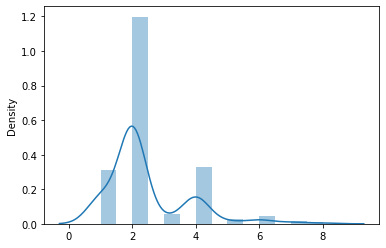

In [27]:
import seaborn as sns

sns.distplot(c);

In [6]:
class Switches(DataSeparator):
    
    def switches(self, df):
        id_list = df['id'].unique()
        switch_list, time_list, injs_list = [], [], []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            switch_count = 0
            for i in range(len(pdf)-1):
                if pdf['Drug'].iloc[i] != pdf['Drug'].iloc[i+1]:
                    switch_count += 1
                    end = pd.to_datetime(pdf.admission_date.iloc[i+1], dayfirst=True)
                    start = pd.to_datetime(pdf.admission_date.iloc[0], dayfirst=True)
                    switch_time = (end - start).days / 7
                    time_list.append(switch_time)
                    injs_list.append(i)
            switch_list.append(switch_count)
        return np.mean(switch_list), np.median(switch_list), np.std(switch_list), min(switch_list), max(switch_list), np.mean(time_list), np.mean(injs_list)
    
    def switches_table(self):
        df_list = DataSeparator.get_dataframes(self)
        names = ['Lucentis', 'Eylea', 'Multiple', 'Improved', 'Not_Improved', 'Overall', 'Luc_to_Eyl', 'Eyl_to_Luc']
        means, medians, stds, mins, maxs, times, injs = [], [], [], [], [], [], []
        for df in df_list:
            mean, median, std, minm, maxm, time, inj = self.switches(df)
            means.append(mean), medians.append(median)
            stds.append(std), mins.append(minm), maxs.append(maxm)
            times.append(time), injs.append(inj)
        dict = {'Type': names, 'Mean': means, 'Median': medians, 
                'Std': stds, 'Min': mins, 'Max': maxs, 'Time': times, 'Injections': injs}
        df = pd.DataFrame(dict)
        df.set_index('Type', inplace=True)
        return df

In [7]:
test = Switches('all')
test.switches_table()

,Mean,Median,Std,Min,Max,Time,Injections
Type,,,,,,,
Lucentis,0.000000,0.0,0.000000,0,0,NaN,NaN
Eylea,0.000000,0.0,0.000000,0,0,NaN,NaN
Multiple,2.936842,2.0,2.374472,1,14,61.801843,9.053763
Improved,9.171271,7.0,7.824628,0,42,85.854475,12.104217
Not_Improved,8.029851,5.0,9.602503,0,54,89.425651,12.602230
Overall,10.423387,8.0,9.480996,0,64,84.608124,13.550484
Luc_to_Eyl,2.783333,2.0,2.497276,1,14,60.452524,8.922156
Eyl_to_Luc,4.210526,4.0,1.935240,1,8,47.830357,7.437500


In [56]:
class Upload:
    """
    A class used to upload the required dataframes to Google Drive.

    ...

    Attributes
    ----------
    folder : str
        a formatted string to determine the folder to upload to
        options: 'pharma_reports', 'research'
    dr_name : str
        a formatted string of audited doctor, used to create folder in drive
    file_list : list
        a list of files to upload to Drive

    Methods
    -------
    set_folder(self)
        Determines the path ID of the folder to upload to.
    view_files(self)
        View all folders and file in the Google Drive.
    create_folder(self)
        Create folder on Google Drive.
    upload_files(self)
        Upload the specified file of the object.
    """
    
    def __init__(self, folder, dr_name, file_list):
        self.folder = folder
        self.dr_name = dr_name
        self.file_list = file_list
        
    def retrieve_files(self):
        """
        Returns a list of files in the main directory to upload.
        """
        if self.file_list == 'all':
            return ['initialmetrics.csv', 'drug_int_metrics.csv', 'interval_metrics.csv',
                    'interval_distribution.csv', 'int_dist_plot.csv',
                    'visual_metrics.csv', 'drug_dist_table.csv', 'va_distributions.csv',
                    'ut_plot.png', 'anchor.csv']
        
    def set_folder(self):
        """
        Determines the path ID of the folder to upload to.
        Input: self.
        Output: folder_id (PyDrive object)
        """
        if self.folder == 'pharma_reports':
            folder_id = '1INvWwtJhtiD4vqCEpehd4RT06I1-50pU'
        elif self.folder == 'research':
            folder_id = '1GuUeRc7Zqe5GdM1dmJOUF6VPW5NklH-R'
        else:
            folder_id = '1INvWwtJhtiD4vqCEpehd4RT06I1-50pU'
        return folder_id
    
    def view_files(self):
        """
        View all folders and file in the Google Drive.
        """
        fileList = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
        for file in fileList:
            print('Title: %s, ID: %s' % (file['title'], file['id']))
            
    def create_folder(self):
        """ 
        Create folder on Google Drive.
        """
        folder_name, parent_folder_id = self.dr_name, self.set_folder()
        folder_metadata = {'title': folder_name,
                           # Define the file type as folder
                           'mimeType': 'application/vnd.google-apps.folder',
                           # this is ID of the parent folder        
                           'parents': [{"kind": "drive#fileLink", "id": parent_folder_id}]}
        folder = drive.CreateFile(folder_metadata)
        folder.Upload()
        # Return folder informations
        return folder['id']
                
    def upload_files(self):
        """
        Upload the specified file of the object.
        """
        folder_id = self.create_folder()
        upload_file_list = self.retrieve_files()
        for upload_file in upload_file_list:
            gfile = drive.CreateFile({'parents': [{'id': folder_id}]})
            # Read file and set it as the content of this instance.
            gfile.SetContentFile(upload_file)
            gfile.Upload() # Upload the file.

In [57]:
def generate_audit(dr_name, folder='pharma_reports', file_list='all', df_list='all'):
    initialmetrics = InitialMetrics(df_list)
    initialmetrics.upload_results_table()
    interval = Interval('all')
    interval.upload_results_table()
    vision = Vision('all')
    vision.upload_results_table()
    plot = Utilisation('all')
    plot.plot_ut()
    anchor = Anchor('all', 3)
    anchor.upload_results_table()
    to_upload = Upload(folder, dr_name, file_list)
    to_upload.upload_files()
    to_delete = to_upload.retrieve_files()
    for file in to_delete:
        os.remove(file)
    print("The upload is complete.")

The upload is complete.


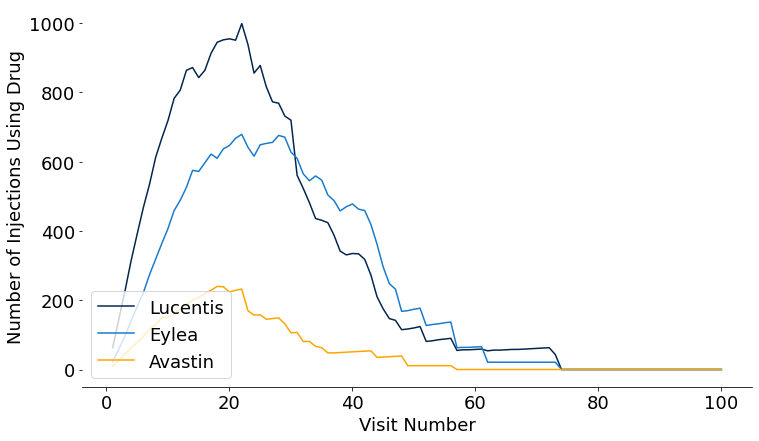

In [58]:
generate_audit('EricNew')

In [65]:
df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/eric_mayer.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,admission_date,DoctorName,visual_acuity,Drug,InjNext,NextInt,Laterality,Interval
0,0,286,1393,1,2019-08-10,Dr. Eric Mayer,89.0,NaN,NaN,NaN,Right,0.0
1,1,287,1394,1,2019-08-10,Dr. Eric Mayer,NaN,Lucentis,Lucentis,4.0,Right,0.0
2,2,288,1395,1,2019-10-29,Dr. Eric Mayer,85.0,Lucentis,Lucentis,4.0,Right,11.0
3,3,289,1396,1,2019-11-26,Dr. Eric Mayer,85.0,Lucentis,Lucentis,6.0,Right,4.0
4,4,290,1397,1,2020-01-14,Dr. Eric Mayer,85.0,Lucentis,Lucentis,7.0,Right,7.0


In [82]:
a = luc.NextInt.value_counts().sort_index()

In [83]:
a

3.0       8
4.0     250
5.0      18
6.0     189
7.0      20
8.0     172
9.0      28
10.0    152
11.0     23
12.0    235
13.0      8
14.0     11
Name: NextInt, dtype: int64

<AxesSubplot:>

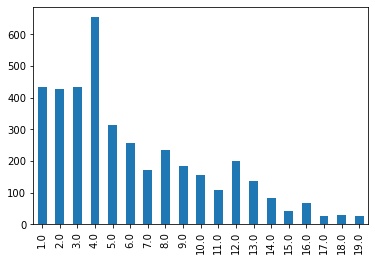

In [20]:
df['Interval'].value_counts().sort_index().plot(kind='bar')

In [23]:
test = DataSeparator('all')
df_list = test.get_dataframes()
luc, eyl, mult = df_list[0], df_list[1], df_list[2]

In [53]:
def interval_distribution(df):
    # df = df[(df.NextInt > 0) & (df.NextInt < 20)]
    a = df.NextInt.value_counts().sort_index().to_list()
    total = np.sum(a)
    return [(x/total)*100 for x in a]

In [78]:
len(mult.NextInt.value_counts().sort_index().to_list())

16

In [84]:
def distribution_df(luc, eyl, mult):
    luc_list = [0,0,0] + interval_distribution(luc) + [0,0,0]
    eyl_list = [0,0,0] + interval_distribution(eyl) + [0]
    mult_list = [0, 0] + interval_distribution(mult)
    lengths = [x for x in range(len(luc_list))]
    dict = {'Interval': lengths, 'Lucentis': luc_list,
               'Eylea': eyl_list, 'Multiple': mult_list} 
    df = pd.DataFrame(dict)
    df.set_index('Interval', inplace=True)
    return df.iloc[0:17,:]

In [85]:
dist = distribution_df(luc, eyl, mult)

In [87]:
dist.to_csv('dist.csv')

In [86]:
dist

,Lucentis,Eylea,Multiple
Interval,,,
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.240732
3,0.718133,0.642055,1.540684
4,22.441652,24.879615,52.527684
5,1.615799,2.889246,3.466538
6,16.965889,18.780096,19.932595
7,1.795332,4.654896,1.829562
8,15.439856,22.150883,8.088589
